In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [4]:
def findFiles(path):
    return glob.glob(path)

In [5]:
print(findFiles('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [6]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [7]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [8]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [9]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [10]:
category_lines = {}
all_categories = []

In [11]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [12]:
n_categories = len(all_categories)

In [13]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [14]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [15]:
import torch.nn as nn

In [18]:
lstm = nn.LSTM(input_size=n_letters, hidden_size=5, num_layers=1)

In [26]:
inp = lineToTensor('Albert')

NameError: name 'lineToTensor' is not defined

In [27]:
with torch.no_grad():
    output, (hidden_out, c_out) = lstm(inp[0], unsqueeze(0))
    for i in range(1, inp.shape[0]):
        output, (hidden_out, c_out) = lstm(inp[i], unsqueeze(0)), (hidden_out, c_out)

NameError: name 'inp' is not defined

In [28]:
output, hidden_out

NameError: name 'output' is not defined

In [29]:
with torch.no_grad():
    output, (hidden_out, c_out) = lstm(inp)

NameError: name 'inp' is not defined

In [16]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [17]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [18]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [19]:
criterion = nn.NLLLoss()

In [20]:
optimizer = torch.optim.SGD(rnn.parameters(), lr=5e-4)

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    optimizer.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

In [21]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [22]:
n_iters = 100000
print_every = 5000
plot_every = 500

In [23]:
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 21s (5000 5%) 3.1438
0m 44s (10000 10%) 3.2324
1m 5s (15000 15%) 3.0560
1m 25s (20000 20%) 3.2536
1m 45s (25000 25%) 3.0970
2m 5s (30000 30%) 2.2971
2m 26s (35000 35%) 2.1826
2m 47s (40000 40%) 2.0793
3m 7s (45000 45%) 2.8183
3m 28s (50000 50%) 2.2405
3m 48s (55000 55%) 2.3760
4m 9s (60000 60%) 1.8490
4m 30s (65000 65%) 2.3133
4m 50s (70000 70%) 2.1675
5m 11s (75000 75%) 3.5342
5m 31s (80000 80%) 1.9126
5m 52s (85000 85%) 2.9017
6m 12s (90000 90%) 2.9649
6m 33s (95000 95%) 2.9657
6m 53s (100000 100%) 1.8770


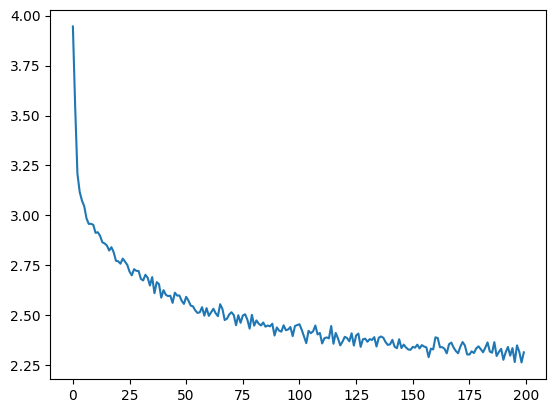

In [24]:
plt.plot(all_losses)

In [25]:
def sample(category, prefix, max_length=20):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        hidden = rnn.initHidden()
        
        output_name = prefix[0]
        inp = inputTensor(prefix[0])

        for i in range(1, len(prefix)):
            output, hidden = rnn(category_tensor, inp[0], hidden)
            output_name += prefix[i]
            inp = inputTensor(prefix[i])

        for i in range(max(0, max_length - len(prefix))):
            output, hidden = rnn(category_tensor, inp[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            inp = inputTensor(letter)

        return output_name

In [26]:
sample('Russian', 'Fa')

'Farishi'

In [27]:
sample('German', 'Fa')

'Farter'

In [28]:
sample('Spanish', 'Fa')

'Faner'

In [29]:
sample('English', 'Fa')

'Farteng'

In [30]:
sample('Chinese', 'Fa')

'Fan'

In [31]:
sample('Greek', 'Fa')

'Faris'